## K-nearest words map
Find and plot the k-nearest words for top tf-idf words in reddit comments corpus from Jan. 2017.
### 1. Reorganize the corpus into a collection documents - one thread per document
First, let's print out one comment and see what it looks like.

In [1]:
import bz2
import json
import time
f_in = bz2.BZ2File("data/2017-01.bz2").readlines() 
# each bytes string is json like in this dataset
now = time.time()
print (f_in[0])

b'{"parent_id":"t1_dbufkak","id":"dbumnvn","edited":false,"created_utc":1483228806,"distinguished":null,"author_flair_css_class":null,"author_flair_text":null,"controversiality":0,"subreddit_id":"t5_2wlj3","retrieved_on":1485679713,"link_id":"t3_5l72cl","author":"twigwam","score":1,"gilded":0,"stickied":false,"body":"OMGosh im an idiot this week.  Thank you","subreddit":"CryptoCurrency"}\n'


Now let's aggregates comments based on parent_id.

In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w*[A-z]+\w*')
comments = [(json.loads(line)['link_id'], tokenizer.tokenize(json.loads(line)['body'].lower())) for line in f_in]
print ("Tokenization took {}s.".format(time.time() - now))

Tokenization took 16.836188793182373s.


In [3]:
from collections import *
from nltk.corpus import stopwords
import nltk
now = time.time()
documents = defaultdict(list)
tags_of_interest = ['NN', 'NNS', 'NN$', 'VBD', 'VBP', 'VBX', 'VBG', 'VB']
noun_verb = []
eng_stopwords = stopwords.words('english')
for (k,v) in comments:
    noun_verb += [i[0] for i in nltk.pos_tag(v) if i[1] in tags_of_interest]
    filtered_words = [word for word in v if word not in eng_stopwords]
    documents[k] += filtered_words
print ("Documentation took {}s.".format(time.time() - now))

Documentation took 316.23098707199097s.


In [4]:
print(len(comments), len(documents))

156850 9690


### 2. Calculate TF-IDF

In [5]:
now = time.time()
tf_df = defaultdict(Counter)
for item in documents.items():
    document = item[1]
    for word in set(document):
        tf_df[word].update(tf = document.count(word), df = 1)

In [6]:
from math import log
tfidf = {}
N = len(documents)
for (k, v) in tf_df.items():
    tfidf[k] = v['tf']*log(N/v['df'])
sorted_list = sorted(tfidf.items(), key = lambda t:-t[1])
print ("Calculating TFIDF took {}s.".format(time.time() - now))

Calculating TFIDF took 64.12159609794617s.


In [7]:
now = time.time()
noun_verb_unique = list(set(noun_verb))
sorted_clean = [word[0] for word in sorted_list if len(word[0]) > 2 and word[0] in noun_verb_unique]
top100 = sorted_clean[:100]
print ("Sorting took {}s.".format(time.time() - now))

Sorting took 170.67010807991028s.


In [8]:
top100

['bitcoin',
 'segwit',
 'people',
 'block',
 'like',
 'price',
 'think',
 'miners',
 'one',
 'btc',
 'com',
 'time',
 'money',
 'https',
 'get',
 'blocks',
 'core',
 'transactions',
 'even',
 'fork',
 'market',
 'transaction',
 'wallet',
 'see',
 'monero',
 'network',
 'use',
 'way',
 'know',
 'much',
 'nodes',
 'want',
 'make',
 'buy',
 'reddit',
 'need',
 'fees',
 'value',
 'long',
 'good',
 'chain',
 'going',
 'hard',
 'right',
 'size',
 'well',
 'node',
 'point',
 'mining',
 'back',
 'china',
 '[deleted]',
 'fee',
 'say',
 'coins',
 'blockchain',
 'years',
 'coinbase',
 'www',
 'increase',
 'something',
 'support',
 'comments',
 'work',
 'http',
 'sure',
 'take',
 'amp',
 'trading',
 'users',
 'currency',
 'exchanges',
 'exchange',
 'first',
 'yes',
 'things',
 'limit',
 'sell',
 'change',
 'lot',
 'gold',
 'using',
 'thing',
 'better',
 'short',
 'bitcoins',
 'day',
 'said',
 'run',
 'blocksize',
 'pay',
 'chinese',
 'problem',
 'system',
 'someone',
 'post',
 'year',
 'anything',

### 3. Word2Vec representations for top 100 words

In [1]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

In [12]:
len(sorted_clean)

51260

In [20]:
import numpy as np
import json
now = time.time()
w2v = defaultdict(list)
for item in sorted_clean:
    if item in model:
        w2v[item] = model[item].tolist()
with open("intermed/word2vec_google.json", 'w') as f:
    json.dump(w2v, f)
print ("Word to vec mapping took {}s.".format(time.time() - now))

Word to vec mapping took 21.234451055526733s.


### 4. Calculate cosine similarities

Seems like not every word here is included in the GloVe pre-trained word embeddings.

In [49]:
now = time.time()
for word in top100:
    if len(w2v[word]) == 0:
        top100.remove(word)
print (len(top100))

91


In [62]:
def cosine_sim1(vec1, vec2):
    return abs(np.dot(np.transpose(vec1), vec2) / (np.dot(np.transpose(vec1), vec1) + np.dot(np.transpose(vec2), vec2)))

In [44]:
def cosine_sim(vec1, vec2):
    return abs(np.dot(np.transpose(vec1), vec2)) / np.sqrt(np.dot(np.transpose(vec1), vec1) * np.dot(np.transpose(vec2), vec2))

In [63]:
vec1 = np.array([1,1])
vec2 = np.array([1,2])
print(cosine_sim1(vec1, vec2))
print(cosine_sim(vec1, vec2))

0.428571428571
0.948683298051


In [40]:
word_pairs = list(itertools.combinations(top100, 2))
len(word_pairs)

4186

In [50]:
import itertools
cos_sim = defaultdict(float)
word_pairs = list(itertools.combinations(top100, 2))
for pair in word_pairs:
    print(pair)
    cos_sim[pair] = cosine_sim(w2v[pair[0]], w2v[pair[1]])

('people', 'block')
('people', 'like')
('people', 'price')
('people', 'think')
('people', 'miners')
('people', 'one')
('people', 'com')
('people', 'time')
('people', 'money')
('people', 'https')
('people', 'get')
('people', 'blocks')
('people', 'core')
('people', 'transactions')
('people', 'even')
('people', 'fork')
('people', 'market')
('people', 'transaction')
('people', 'wallet')
('people', 'see')
('people', 'network')
('people', 'use')
('people', 'way')
('people', 'know')
('people', 'much')
('people', 'nodes')
('people', 'want')
('people', 'make')
('people', 'buy')
('people', 'reddit')
('people', 'need')
('people', 'fees')
('people', 'value')
('people', 'long')
('people', 'good')
('people', 'chain')
('people', 'going')
('people', 'hard')
('people', 'right')
('people', 'size')
('people', 'well')
('people', 'node')
('people', 'point')
('people', 'mining')
('people', 'back')
('people', 'china')
('people', 'fee')
('people', 'say')
('people', 'coins')
('people', 'years')
('people', 'www

In [51]:
sorted_sims = sorted(cos_sim.items(), key = lambda t:(t[0][0], -t[1]))
print ("Calculating cosine similarities took {}s.".format(time.time() - now))

Calculating cosine similarities took 11.260473728179932s.


In [52]:
print(sorted_sims[:20])

[(('amp', 'chinese'), 0.16417411519614775), (('amp', 'system'), 0.1475035463517754), (('amp', 'someone'), 0.13754097699380846), (('amp', 'lot'), 0.13260062684501756), (('amp', 'pay'), 0.12736983877488953), (('amp', 'anything'), 0.11276261956325069), (('amp', 'code'), 0.11205057158709963), (('amp', 'thing'), 0.10085744541426188), (('amp', 'post'), 0.09333792073475701), (('amp', 'using'), 0.090579465892782859), (('amp', 'users'), 0.088765411900956784), (('amp', 'sell'), 0.086973532087739766), (('amp', 'currency'), 0.074287873994715328), (('amp', 'trading'), 0.071032438932594116), (('amp', 'limit'), 0.067098024300884546), (('amp', 'run'), 0.057413379573022137), (('amp', 'yes'), 0.056531202247298538), (('amp', 'better'), 0.054069593694815551), (('amp', 'year'), 0.051813088123765713), (('amp', 'everyone'), 0.046855113760887572)]


### 5. Construct a list for top-k (k=5) nearest words for each words


Re-order the keywords in a word pair into alphabetic. Keep only the top k pairs with highest similarities. But this doesn't necessarily find the top-k for all the words. This is wrong. 

In [53]:
now = time.time()
ordered_keys = []
for pair in sorted_sims:
    ordered_key = sorted(pair[0])
    ordered_keys.append([ordered_key, pair[1]])
print ("Sorting took {}s.".format(time.time() - now))

Sorting took 0.00698399543762207s.


First, sort the similarities list by the first key word (item\[0\]\[0\]) and the similarity values. 
Take the top k item\[0\]\[1\] for each item\[0\]\[0\] and construct a new list. 
Sort the new list by the second key word (item\[0\]\[1\]) and the similarity values. 
If one item\[0\]\[1\] has more than k pairs, keep the top k pairs with highest similarities and dump the rest. 

In [54]:
k = 5 
N = len(top100)
top_k = []
current_word = ""
past_word = []
for i, pair in enumerate(sorted_sims):
    if current_word != pair[0][0]:
        current_word = pair[0][0]
        top_k += sorted_sims[i : i + 5]

top_k = sorted(top_k, key = lambda t:(t[0][1], -t[1]))
top_k_2 = []
counter = 0
current_word = ""
for pair in top_k:
    if current_word == pair[0][1]:
        counter = counter + 1
    else:
        counter = 0
        current_word = pair[0][1]
    if counter < k:
            top_k_2.append(pair)

Now top_k_2 is the list that we are looking for. 

In [55]:
(len(top_k), len(top_k_2))

(450, 269)

Let's save this data so that we don't have to re-run the whole model when the program crashes.

In [56]:
with open("intermed/top_k_pairs.json", 'w') as f:
    json.dump(top_k_2, f)
f.close()

### extra. Convert Word2vec from .bin to .txt

In [ ]:
# import gensim

# model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
# model.save_word2vec_format('data/GoogleNews-vectors-negative300.txt', binary=False)

### 6. plot the network of similar words
Load the top k pairs from the json file.

In [58]:
import json
with open("intermed/top_k_pairs.json", 'r') as f:
    top_k_pairs = json.load(f)
f.close()
len(top_k_pairs)

269

Set the resolution environment for better quality plots

In [60]:
import networkx as nx
import plotly.plotly as py
from plotly.graph_objs import *

G = nx.Graph()
edges = [(pair[0][0], pair[0][1]) for pair in top_k_pairs[:100]]
edgewidth = [pair[1] * 20 for pair in top_k_pairs[:100]]
G.add_edges_from(edges)

/Users/yize/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning:

Matplotlib is building the font cache using fc-list. This may take a moment.



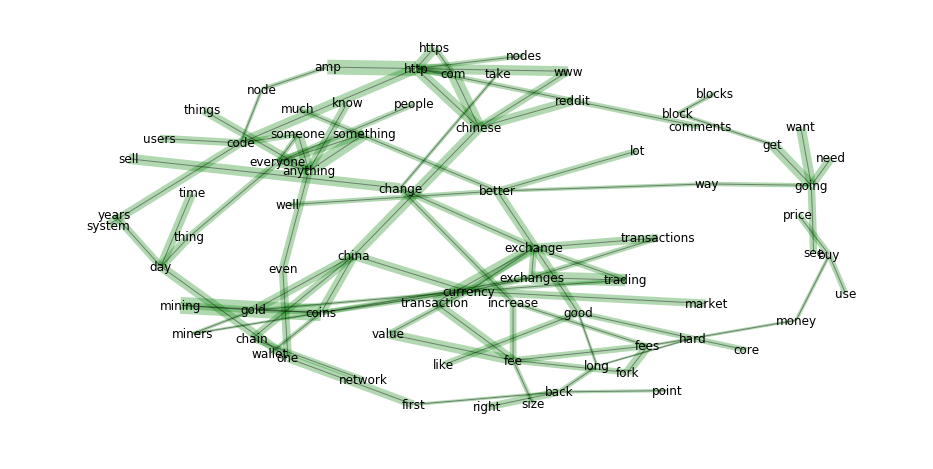

In [61]:
import matplotlib.pyplot as plt

try:
    pos = nx.nx_agraph.graphviz_layout(G)
except:
    pos = nx.spring_layout(G, iterations=20)
    
plt.figure(figsize=(16, 8))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=edgewidth, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_size=5, node_color='w', alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.4, node_size=0, width=1, edge_color='k')
nx.draw_networkx_labels(G, pos, fontsize=16)
font = {'fontname': 'Helvetica',
        'color': 'k',
        'fontweight': 'bold',
        'fontsize': 16}
plt.axis('off')
plt.savefig("results/top_k_pairs.png", dpi = 600, bbox_inches='tight')
plt.show()